# TD 1: Single Layer Perceptron


Goals: 
- check that everyone can run a notebook with appropriate config
- play around with the single-layer perceptron

Hédi Hadiji, 
with bits from Odalric Ambryn-Maillard.

December 2023

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy

import time

import matplotlib.pyplot as plt

If necessary: install pytorch by running 

`pip3 install torch`

(in a a virtual environment)

In [113]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")

python --version = 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
torch.__version__ = 2.0.1
np.__version__ = 1.26.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [114]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[-0.0514,  0.6854],
        [-1.2533, -1.3239],
        [-0.0809, -0.4531]]) 
+
 tensor([[-0.6086, -0.8841],
        [-0.6804, -1.0071],
        [ 0.4571, -1.7025]]) 
=
 tensor([[-0.6600, -0.1987],
        [-1.9337, -2.3310],
        [ 0.3762, -2.1556]])


### Gradient management

In [115]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([-0.9409])
Final estimate: tensor([1.9820])
The final estimate should be close to tensor([2.])


# Setting up a Perceptron experiment

### 1 - Data

In [116]:
class ToyLinearData(): 
    """
        Toy dataset generating linearly separable data with margin gamma. 
    """
    def __init__(self, n, d, gamma=0, w=None):
        self.n = n 
        self.d = d
        self.gamma = gamma
        if w is None:
            w = torch.normal(torch.zeros(d))
        self.w = w / torch.linalg.norm(w)
       
        self.features = torch.zeros((n, d))
        self.labels = torch.zeros((n))
        self.max_norm = 0
        self.w_margin = 1e10

        self.fill_data()

    def fill_data(self):
        for i in range(self.n):
            x, y = self.new_example()
            self.features[i, :] =  x
            self.labels[i] = y
            self.max_norm = max(torch.norm(x), self.max_norm)
            self.w_margin = min(abs(torch.dot(self.w, x)), self.w_margin)

    def new_example(self):
        """
            Generates a gaussian vector with zero mean and identity / sqrt(d) covariance, then
            moves it in the direction of w or in the opposite direction, to guarantee margin.
        """
        # Gaussian vectors typically have norm around sqrt(d), so we normalise
        x = torch.normal(torch.zeros(self.d)) / np.sqrt(self.d) 
        value = torch.dot(x, self.w)
        if value >= 0: 
            x = x + self.gamma * self.w 
            y = 1
        elif value < 0:
            x = x - self.gamma * self.w 
            y = -1
        return x, y

    def __len__(self):
        return self.n


class ToySphericalData: 
    """
        Generate toy data that is not linearly separable
    """
    def __init__(self, n, d, max_rad=1, threshold_rad=.5):
        self.n = n 
        self.d = d
       
        self.features = torch.zeros((n, d))
        self.labels = torch.zeros((n))

        self.max_rad = max_rad
        self.threshold_rad = threshold_rad

        self.fill_data()

    def fill_data(self):
        for i in range(self.n): 
            r = np.random.rand() * self.max_rad
            x = torch.normal(torch.zeros(d))
            x = r / torch.norm(x) * x
            self.features[i, :] =  x
            if r > self.threshold_rad:
                self.labels[i] = 1
            else: 
                self.labels[i] = -1

    def __len__(self):
        return self.n

def plot_data(data):
    'Scatter plot for d = 2. Quite slow'
    for i in range(len(data)): 
        if data.labels[i] == 1:
            plt.scatter(data.features[i][0], data.features[i][1], color='blue')#, label='+1')
        else: 
            plt.scatter(data.features[i][0], data.features[i][1], color='red')#, label='-1')



Margin of w :  0.0013
Max norm :  2.1950
True w : tensor([-0.7781, -0.6282])


(-1.960903126001358,
 1.8677626430988312,
 -2.4026930212974547,
 2.2392587542533873)

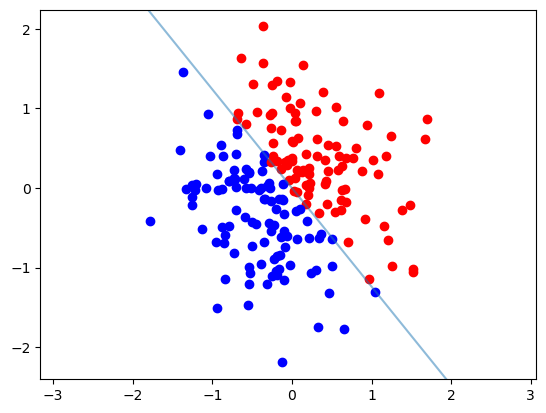

In [117]:
n = 200
d = 2
gamma = 0
data = ToyLinearData(n, d, gamma=gamma)
print(f'Margin of w : {data.w_margin: .4f}')
print(f'Max norm : {data.max_norm: .4f}')
print(f'True w : {data.w}')

plot_data(data)

plt.axline((0, 0), slope=-data.w[0] / data.w[1], color='C0', alpha=.5, label='True Hyperplane')

plt.axis('equal')


(-1.0874035000801086,
 1.082511031627655,
 -1.0864513635635376,
 1.0809491395950317)

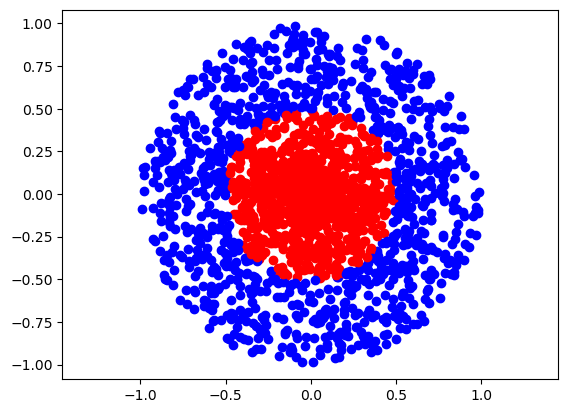

In [118]:
n = 500
d = 2
data = ToySphericalData(n, d)

plot_data(data)

plt.axis('equal')

## 2 - Implementing the Perceptron

In [119]:
class Perceptron(): 
    """
        Single-layer Perceptron
    """
    def __init__(self, dim): 
        self.dim = dim
        self.w = torch.zeros(dim)

        self.margin_mistake_counter = 0

    def predict(self, x): 
        if torch.dot(self.w, x) > 0: 
            return 1
        else: 
            return -1
    
    def update_margin_mistake(self, x, y): 
        self.w += y * x
        self.margin_mistake_counter += 1

In [130]:
def train_perceptron(alg, data, t_lim=100_000): 
    converged = False
    t = 0 
    while not (converged) and t < t_lim:
        shuffled_indices = np.arange(len(data))
        #np.random.shuffle(shuffled_indices)
        clean_pass = True
        for i in shuffled_indices: 
                                                                                                                            if torch.dot(alg.w, x) * y < 1: 
                alg.update_margin_mistake(x, y)
                clean_pass = False
            t += 1
        if clean_pass: 
            converged = True
    return converged

In [131]:
n = 100
d = 2
gamma = .5
data = ToyLinearData(n, d, gamma=gamma)
alg = Perceptron(d)


# 3 - Testing the Perceptron

In [123]:
n = 100
d = 2
gamma = 0.1
data = ToyLinearData(n, d, gamma=gamma)
alg = Perceptron(d)

### Run the code below a few times to see how the Perceptron behaves.

You can restart and initialize the algorithm again by running the cell above.

Point selected leads to a margin mistake
Normalized Alg w : tensor([0.2283, 0.9736])
True w:  tensor([-0.6492,  0.7607])


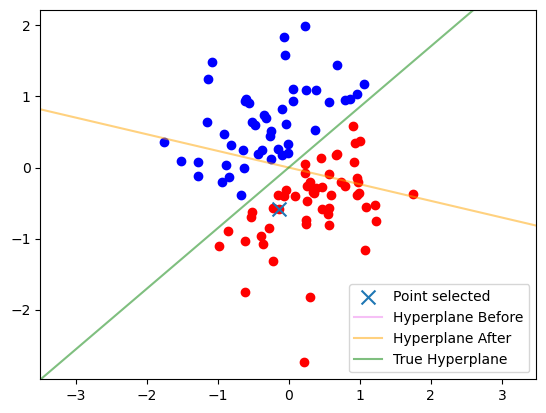

In [124]:
plot_data(data)

i = np.random.randint(len(data))
x, y = data.features[i], data.labels[i]
plt.scatter(x[0], x[1], marker='x', s=100, label='Point selected')

plt.axline((0, 0), slope=-alg.w[0] / alg.w[1], color='violet', alpha=.5, label='Hyperplane Before')

if torch.dot(alg.w, x) * y < 1: 
    alg.update_margin_mistake(x, y)
    print('Point selected leads to a margin mistake')
else:
    print('Point selected is well classified with a margin: no update')

plt.axline((0, 0), slope=-alg.w[0] / alg.w[1], color='orange', alpha=.5, label='Hyperplane After')

plt.axline((0, 0), slope=-data.w[0] / data.w[1], color='green', alpha=.5, label='True Hyperplane')

print('Normalized Alg w :',  alg.w / torch.norm(alg.w))
print('True w: ', data.w)

plt.legend()
plt.axis('equal')
plt.show()

### Non-separable data

In [125]:
n, d = 100, 2
data = ToySphericalData(n, d)

Point selected leads to a margin mistake
Alg w : tensor([-0.1714,  0.3209])


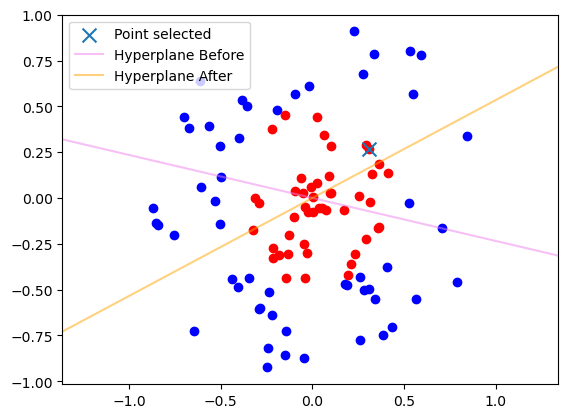

In [126]:
plot_data(data)

i = np.random.randint(len(data))
x, y = data.features[i], data.labels[i]
plt.scatter(x[0], x[1], marker='x', s=100, label='Point selected')

plt.axline((0, 0), slope=-alg.w[0] / alg.w[1], color='violet', alpha=.5, label='Hyperplane Before')

if torch.dot(alg.w, x) * y < 1: 
    alg.update_margin_mistake(x, y)
    print('Point selected leads to a margin mistake')
else:
    print('Point selected is well classified with a margin: no update')

plt.axline((0, 0), slope=-alg.w[0] / alg.w[1], color='orange', alpha=.5, label='Hyperplane After')

print('Alg w :',  alg.w)
#print('True w: ', data.w)

plt.legend()
plt.axis('equal')
plt.show()

### Just run the algorithm in higher dim to check

In [134]:
n, d, gamma = 100, 2, 0
data = ToyLinearData(n, d, gamma=gamma)

alg = Perceptron(d)
converged = train_perceptron(alg, data, t_lim=1_000_000)
print(f'Converged: {converged}')

print(alg.w / torch.norm(alg.w))
print(data.w)

Converged: True
tensor([0.6950, 0.7190])
tensor([0.6299, 0.7767])


In [135]:
n, d = 200, 10
data = ToySphericalData(n, d)

alg = Perceptron(d)
converged = train_perceptron(alg, data, t_lim=100_000)
print(f'Converged: {converged}')

print(alg.w / torch.norm(alg.w), torch.norm(alg.w))

Converged: False
tensor([-0.3983,  0.5476,  0.0862, -0.0950,  0.4477, -0.0551, -0.2822, -0.2792,
         0.2330, -0.3312]) tensor(4.4352)


# 2 - Optimization of the Perceptron

In [136]:
ds = [100 * (i+1) for i in range(20)]
n_ds = len(ds)
N_mc = 20
all_mistakes = np.zeros((n_ds, N_mc))

n = 1000
gamma = .1
norms = np.zeros((n_ds, N_mc))
margins = np.zeros((n_ds, N_mc))

all_converged = True

for i, d in enumerate(ds):
    for j in range(N_mc):
        data = ToyLinearData(n, d, gamma=gamma)
        alg = Perceptron(d)
        converged = train_perceptron(alg, data, t_lim=100_000)
        if not (converged):
            print('Perceptron did not converge')
        all_converged = converged and all_converged
        all_mistakes[i, j] = alg.margin_mistake_counter
        norms[i, j] = data.max_norm
        margins[i, j] = data.w_margin
    

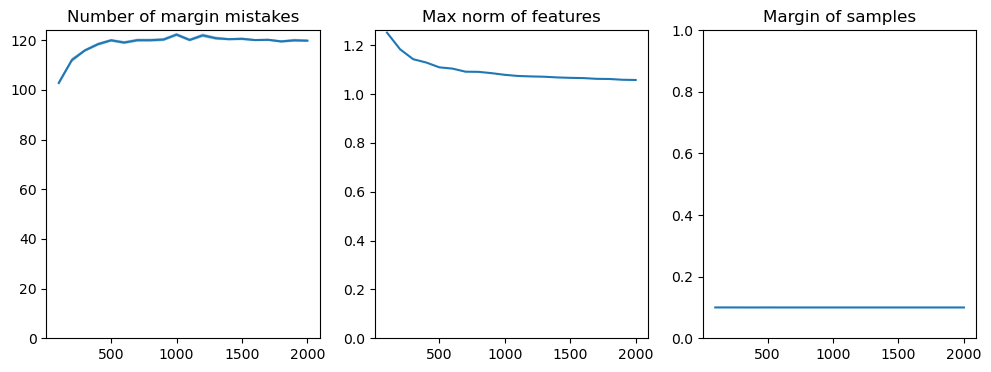

In [139]:
avg_mistakes = np.mean(all_mistakes, axis=1)
std_mistakes = np.std(all_mistakes, axis=1) / np.sqrt(N_mc)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].set_title('Number of margin mistakes')
axs[0].plot(ds, avg_mistakes )
axs[0].fill_between(ds, (avg_mistakes - std_mistakes), (avg_mistakes + std_mistakes), alpha=0.4)
axs[0].set_ylim(0)

axs[1].set_title('Max norm of features')
axs[1].plot(ds, np.mean(norms, axis=1))

axs[2].set_title('Margin of samples')
mean_margins = np.mean(margins, axis=1)
axs[2].plot(ds, mean_margins)

axs[1].set_ylim(0)
axs[2].set_ylim(0, max(1, max(mean_margins)))
plt.show()

# 2- Generalization

In [140]:
n = 10
d = 10
gamma = .1

data = ToyLinearData(n, d, gamma=gamma)
alg = Perceptron(d)
converged = train_perceptron(alg, data, t_lim=100_000)


In [144]:
def test(alg, data, N_test): 
    '''
        Generates a test set and returns the average 
        error on this test set. 
    '''
    score = torch.zeros(N_test)
    for j in range(N_test): 
        x, y = data.new_example()
        score[j] = alg.predict(x) * y
    return 1 - torch.mean(score)

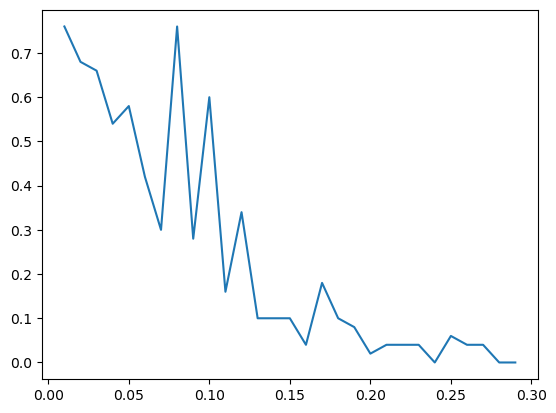

In [150]:
gammas = [.01 * i for i in range(1,30)]
n_train = 10
d = 50

n_gammas = len(gammas)
N_test = 100
errors = torch.zeros(n_gammas)

for i, gamma in enumerate(gammas): 
    data = ToyLinearData(n_train, d, gamma=gamma)
    alg = Perceptron(d)
    converged = train_perceptron(alg, data, t_lim=1_000_000)
    if not (converged):
        print('Perceptron did not converge')
    errors[i] = test(alg, data, N_test)

plt.plot(np.array(gammas), errors)
plt.show()

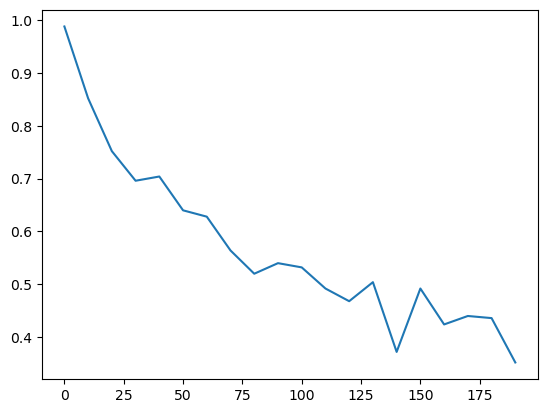

In [151]:
n_trains = [10 * i for i in range(20)]
d = 100

gamma = 0.0

number_of_trainings = len(n_trains)
N_test = 500
errors = torch.zeros(number_of_trainings)

for i, n_train in enumerate(n_trains): 
    data = ToyLinearData(n_train, d, gamma=gamma)
    alg = Perceptron(d)
    converged = train_perceptron(alg, data, t_lim=1_000_000)
    if not (converged):
        print('Perceptron did not converge')
    
    errors[i] = test(alg, data, N_test)

plt.plot(n_trains, errors)